**Example notebook of ace_gridder**

This notebook shows how to use the ace_gridder package to build and analyse a grid with 20 points along each axis.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import time

**Part 1: Creation**

Import GridConstructor

In [2]:
from ace_gridder.grid_constructor import GridConstructor

Define grid parameters

In [3]:
species = ['H2', 'N2', 'H2O', 'CH4', 'CO2', 'CO', 'He', 'NH3', 'HCN']

Z_min = 0.01
Z_max = 2000
Z_scaling = 'logarithmic'

CO_min = 0.001
CO_max = 3
CO_scaling = 'linear'

T_min = 200
T_max = 4000
T_scaling = 'linear'

P_min = 1e-5
P_max = 1e6
P_scaling = 'logarithmic'

minima = (Z_min, CO_min, T_min, P_min)
maxima = (Z_max, CO_max, T_max, P_max)
scaling = (Z_scaling, CO_scaling, T_scaling, P_scaling)

Create GridConstructor object

In [4]:
constructor = GridConstructor(minima=minima, maxima=maxima, scaling=scaling, species=species)

Use GridConstructor to create the grid

In [5]:
n = 20

wdir = '/Datasets/'
name = f'grid_n{n}.hdf5'

constructor.construct_grid(wdir, name, n=n)

100%|██████████| 400/400 [00:24<00:00, 16.44it/s] 


**Part 2: Analysis**

Import GridInterpolator

In [6]:
from ace_gridder.grid_interpolator import GridInterpolator

Load data

In [7]:
interpolator = GridInterpolator()
interpolator.load_data(wdir, name)

Get important variables

In [8]:
data = interpolator.get_data()
species = interpolator.get_species()

metallicities = interpolator.get_metallicity_axis_values()
co_ratios     = interpolator.get_co_ratio_axis_values()
temperatures  = interpolator.get_temperature_axis_values()
pressures     = interpolator.get_pressure_axis_values()

scaling = interpolator.get_axis_scaling()

map_converged = interpolator.get_converged_map()
map_eroded = interpolator.get_eroded_map()

Show what portion of the grid is converged and roughly on what percentage of the parameter space interpolation can occur

In [9]:
print(f'{np.sum(map_converged)}/{n**4} converged')
print(f'{(np.sum(map_eroded)/(n**4)*100):.1f}% ready for interpolation')

157785/160000 converged
86.6% ready for interpolation


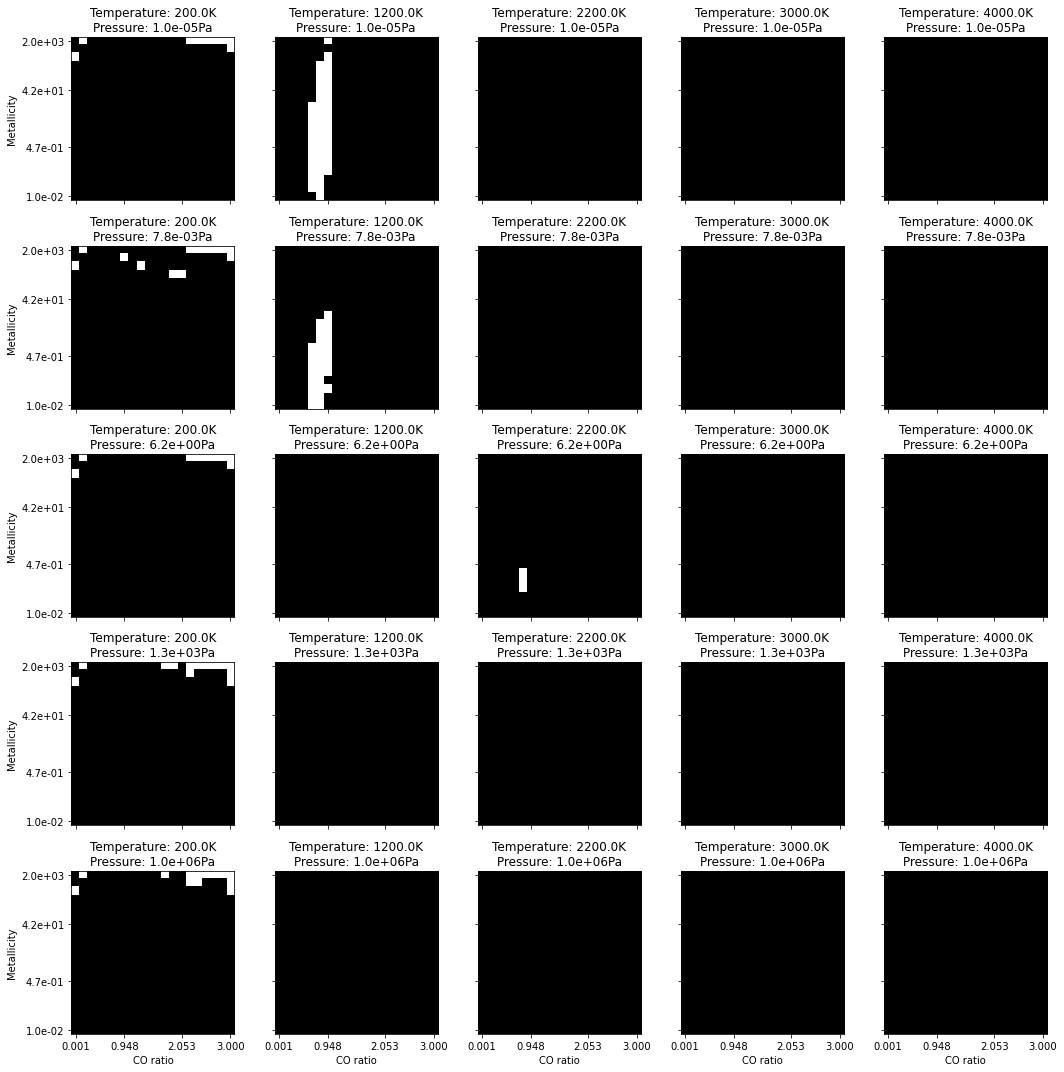

In [10]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15))

slices = [0, 5, 10, 14, 19]

tick_indices = [0, 6, 13, 19]
tick_co_ratio    = [f'{co_ratios[i]:.3f}'     for i in tick_indices]
tick_metallicity = [f'{metallicities[i]:.1e}' for i in tick_indices]

for row, P_index in enumerate(slices):
    for col, T_index in enumerate(slices):
        ax = axes[row, col]
        slice_2d = map_converged[:, :, T_index, P_index]
        
        im = ax.imshow(slice_2d, origin='lower', cmap='gray_r', vmin=0, vmax=1)
        
        ax.set_xticks(tick_indices)
        ax.set_yticks(tick_indices)
        ax.set_xticklabels(['' for i in range(len(tick_indices))])
        ax.set_yticklabels(['' for i in range(len(tick_indices))])
        ax.set_title(f'Temperature: {temperatures[T_index]:.1f}K\nPressure: {pressures[P_index]:.1e}Pa')
        
        if P_index == slices[-1]:
            ax.set_xlabel('CO ratio')
            ax.set_xticklabels(tick_co_ratio)
        if T_index == 0:
            ax.set_ylabel('Metallicity')
            ax.set_yticklabels(tick_metallicity)

plt.tight_layout()
plt.show()

List of test parameters

In [11]:
np.random.seed(0)
test_points = interpolator.get_random_params(10000)

mask = interpolator.is_interpolable(test_points)
test_points = np.array([p for p, m in zip(test_points, mask) if m])

print(f'Length of test point list: {len(test_points)}')

Length of test point list: 8502


List of acepython results for test parameters

In [12]:
t1 = time.perf_counter()
species, VMR_acepython = interpolator.VMR_acepython(test_points)
t2 = time.perf_counter()
print(f'ACEPython runtime: {t2 - t1:.4f} seconds')

ACEPython runtime: 36.7795 seconds


Get RegularGridInterpolator

In [13]:
interp_linear = interpolator.get_interpolator('linear', scaling=scaling)

Use RegularGridInterpolator to interpolate the grid at the test_points

In [14]:
#scale test points such that interpolation happends in appropriate space
test_points_scaled = interpolator.scale_params(test_points, scaling=scaling)

t1 = time.perf_counter()
species, VMR_interp_linear = interpolator.interpolate(test_points_scaled, interp_linear)
t2 = time.perf_counter()

print(f"Interpolate linear runtime on n={n} grid: {t2 - t1:.4f} seconds")

Interpolate linear runtime on n=20 grid: 0.0217 seconds


Calculate and plot errrors

In [15]:
LE_linear = interpolator.calculate_logarithmic_error(VMR_interp_linear, VMR_acepython).T

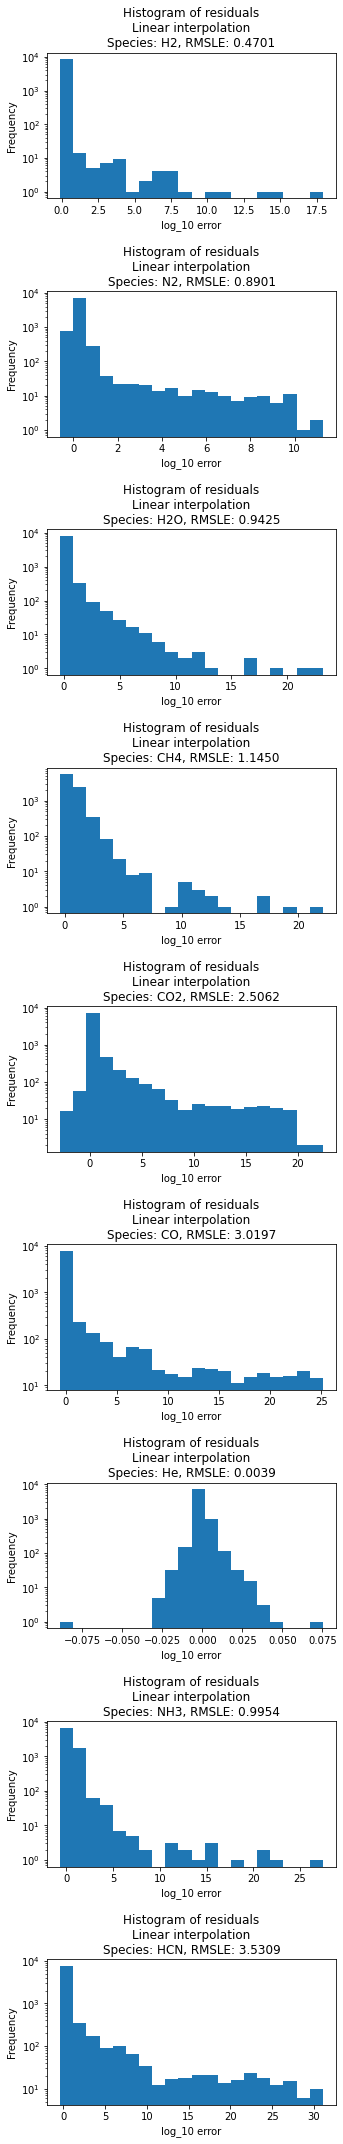

In [16]:
fig, axs = plt.subplots(9, 1, figsize=(5, 30))

for i in range(len(species)):
    RMSLE_linear = np.mean(np.abs(LE_linear[i])**2)**0.5
    
    axs[i].hist(LE_linear[i], bins=20)
    
    axs[i].set_xlabel("log_10 error")
    axs[i].set_ylabel("Frequency")
    axs[i].set_yscale('log')
    
    axs[i].set_title(f'Histogram of residuals\nLinear interpolation\nSpecies: {species[i]}, RMSLE: {RMSLE_linear:.4f}')

plt.tight_layout(pad=1.5)
plt.show()

In [17]:
RMSLE_linear = [np.mean(np.abs(LE_linear[i])**2)**0.5 for i in range(len(species))]

print(f'Linear RMSLE averaged over all species: {np.mean(RMSLE_linear):.4f}')

Linear RMSLE averaged over all species: 1.5004


Take high error point and plot its neighborhood

In [18]:
test_point_index = np.where(LE_linear[0] > 16)[0][0]
print(f'H2, index: {test_point_index}')

H2, index: 4616


In [19]:
axes = ('metallicity:', 'C/O ratio:', 'temperature:', 'pressure:')
for ax, value in zip(axes, test_points[test_point_index]):
    print(f'{ax:>13} {value:>9.2f}')

 metallicity:   1480.82
   C/O ratio:      1.22
 temperature:    218.85
    pressure: 302985.28


In [20]:
i = np.searchsorted(metallicities, test_points[test_point_index, 0], side='right') - 1
j = np.searchsorted(co_ratios,     test_points[test_point_index, 1], side='right') - 1
k = np.searchsorted(temperatures,  test_points[test_point_index, 2], side='right') - 1
l = np.searchsorted(pressures,     test_points[test_point_index, 3], side='right') - 1
slice_metallicity = data[:,j,k,l]
slice_co_ratio    = data[i,:,k,l]
slice_temperature = data[i,j,:,l]
slice_pressure    = data[i,j,k,:]

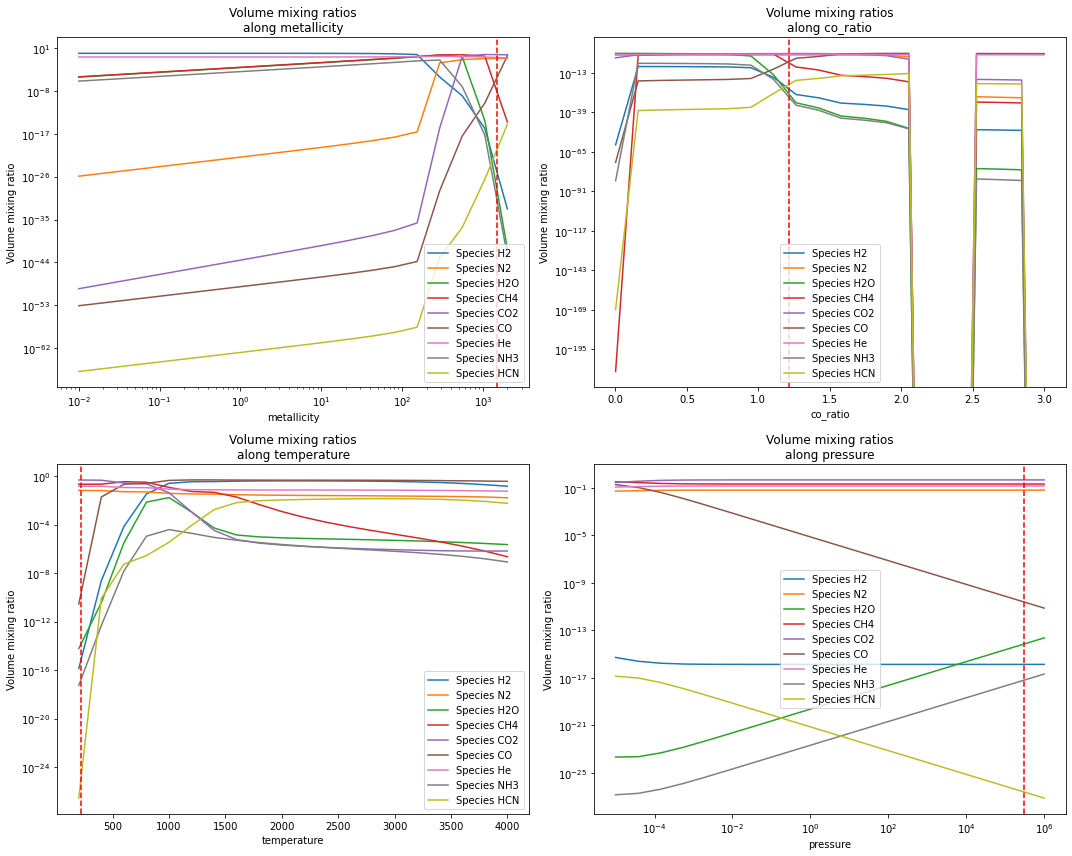

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
all_slices = [slice_metallicity, slice_co_ratio, slice_temperature, slice_pressure]
x_axis_values = [interpolator.metallicities, interpolator.co_ratios, interpolator.temperatures, interpolator.pressures]
x_axis_label = ['metallicity', 'co_ratio', 'temperature', 'pressure']
x_axis_scaling = ['log' if x == 'logarithmic' else x for x in scaling]

species = interpolator.stored_species

for i, slice_i in enumerate(all_slices):
    ax = axes[i // 2, i % 2]
    y_vals = slice_i.T
    for j in range(len(species)):
        ax.plot(x_axis_values[i], y_vals[j], label=f"Species {species[j]}")
    ax.axvline(x=test_points[test_point_index, i], color='red', linestyle='--')
    
    ax.set_xlabel(x_axis_label[i])
    ax.set_xscale(x_axis_scaling[i])
    ax.set_ylabel('Volume mixing ratio')
    ax.set_yscale('log')
    ax.set_title(f'Volume mixing ratios\nalong {x_axis_label[i]}')
    ax.legend()

plt.tight_layout()
plt.show()